In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from astropy.io import fits
import numpy as np
import hcipy
import scipy.io # used for importing .mat files

import pastis.util as util
from pastis.config import CONFIG_PASTIS
from pastis.simulators.scda_telescopes import HexRingAPLC

os.chdir('../ULTRA')
from config import CONFIG_ULTRA

In [2]:
data_path = CONFIG_ULTRA.get('local_path', 'local_data_path')
analysis_path = CONFIG_ULTRA.get('local_path', 'local_analysis_path')

#### Get open loop and close loop time series data. 

In [3]:
open_loop = np.genfromtxt(os.path.join(data_path,'INPUT_MISALIGNMENTS.txt'),  delimiter=';')
close_loop = np.genfromtxt(os.path.join(data_path,'RESIDUAL_MISALIGNMENTS.txt'),  delimiter=';')

print("open-loop data shape:", open_loop.shape)
print("close-loop data shape:", open_loop.shape)

open-loop data shape: (20, 2406)
close-loop data shape: (20, 2406)


#### Set the type of data you want to analyze, i.e. whether open loop or close loop. 

In [4]:
time_series = close_loop

#### Get pre-saved OPDs corresponding to 1 micron dx, dy, dz, rdx, rdy, rdz 

In [5]:
tel2_actuators = 0.5 * fits.getdata(os.path.join(analysis_path, 'optical_sensitvity.fits'))

Note: I'm multiplying here 0.5 to convert to surface units. 

####  Instantiate the 2Hex SCDA Simulator

/opt/miniconda3/envs/ultra-pastis/lib/python3.10/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


contrast_floor: 4.171337358217274e-11
Wavelength: 5.000000000000001e-07


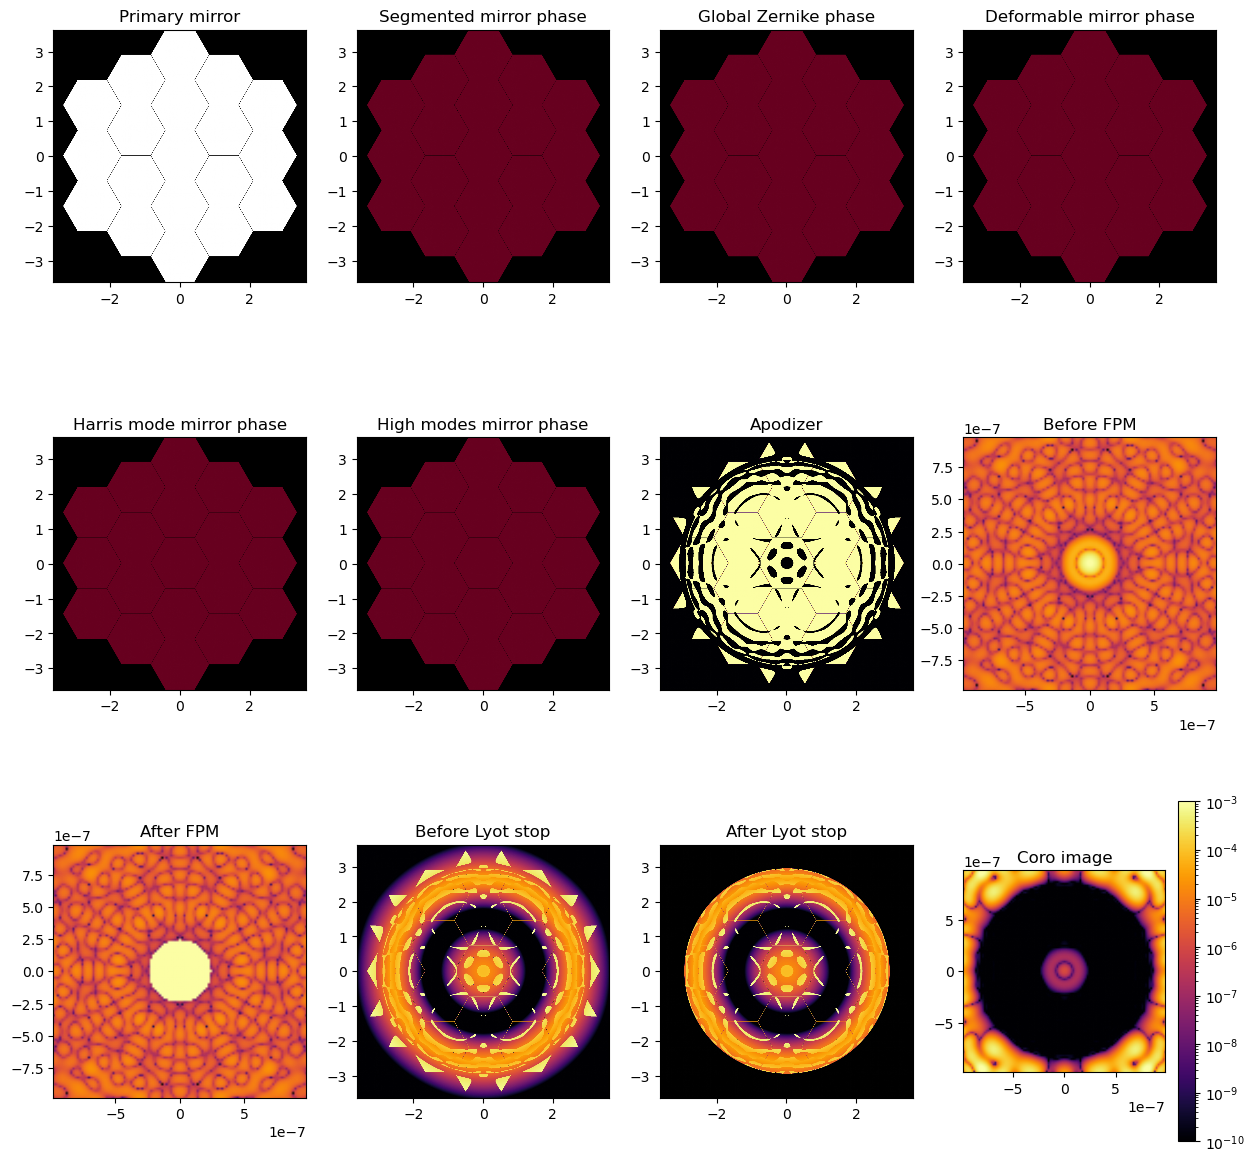

In [6]:
optics_dir = os.path.join(util.find_repo_location(), 'data', 'SCDA')
NUM_RINGS = 2
sampling = 4

tel2 = HexRingAPLC(optics_dir, NUM_RINGS, sampling)

# Set the total number of hexike polynomials you want over the hexagonal segment.
n_zernikes = 11
tel2.create_segmented_mirror(n_zernikes)

unaberrated_psf, ref, intermediates = tel2.calc_psf(ref=True, display_intermediate=True, 
                                  return_intermediate='intensity',
                                  norm_one_photon=True)

norm = np.max(ref)
normalized_unaberrated_psf = unaberrated_psf / norm

unaberr_roi = normalized_unaberrated_psf * tel2.dh_mask
contrast_floor = np.mean(unaberr_roi[np.where(tel2.dh_mask != 0)])


print("contrast_floor:", contrast_floor)
print("Wavelength:", tel2.wvln)

#### Map HWO segment number to the SCDA segment number:

In [7]:
hwo_to_scda = {"1": 4, "2": 5, "3": 6, "4":7, "5":2, "6":3, "7":12, "8":13, "9":14, "10":15,
               "11": 16, "12":17, "13":18, "14":19, "15":8, "16":9, "17":10, "18":11, "19":1}

hwo_scda_segments = np.array([4, 5, 6, 7, 2, 3, 12, 13, 14, 15, 16, 17, 18, 19, 8, 9, 10, 11, 1])

#### Load coefficients from .mat file

In [8]:
hwo_sensitivities = scipy.io.loadmat(os.path.join(data_path, 'HWO_sens_old.mat'))
hwo_table = hwo_sensitivities['HWO_sens']
first_element = hwo_table[0,0]
data_list = first_element.tolist()  # tuple of length 4

hwo_hexike_coeffs = data_list[0]  # ndarray of shape (11, 19, 6)
mask = data_list[1]    # ndarray of shape (256, 256, 19, 6)
dopd = data_list[2]    # ndarray of shape (256, 256, 19, 6)
units = data_list[3]   # ndarray of shape (1,) where the only element is a string

#### Plot OPDs corresponding to PTT via SCDA simulator.
The following plot including colorbars, and RMS should closely match to OPDs pictures from Garrett for the case of PTT, If not matching, there might be some error in sorting the segment number or Zernike coefficients. Simulator uses Noll Convention. 

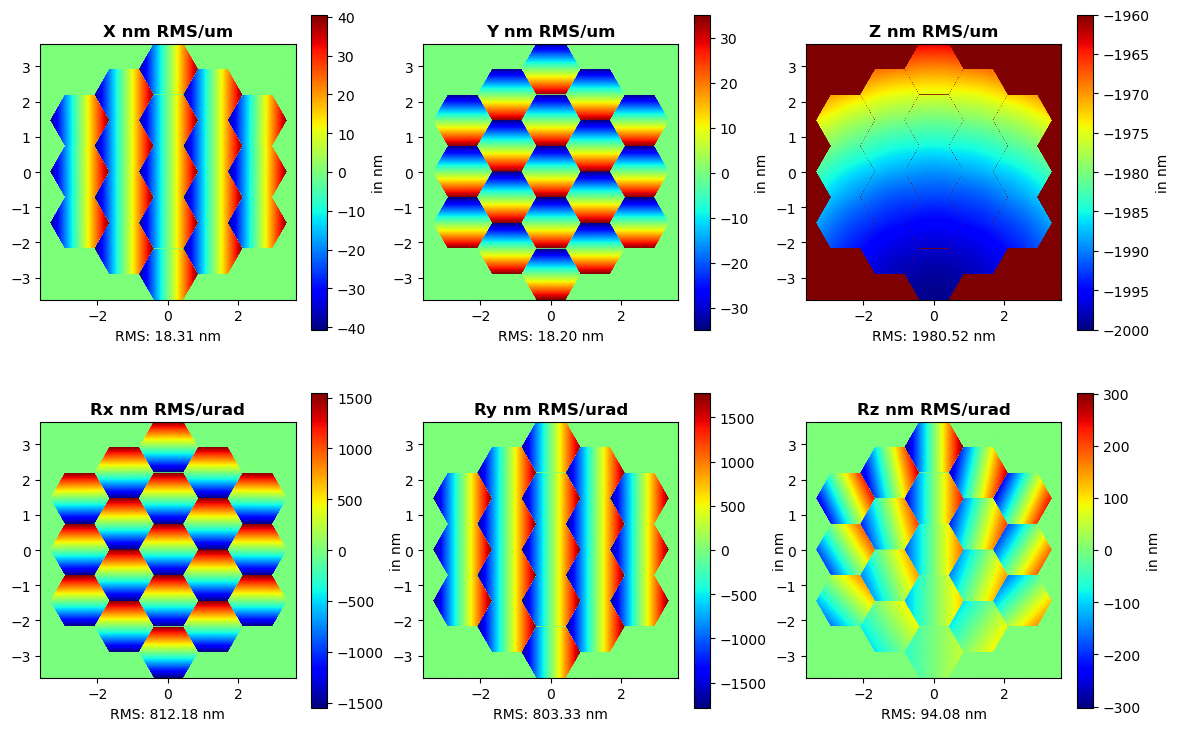

In [9]:
titles = np.array(["X nm RMS/um", "Y nm RMS/um", "Z nm RMS/um", 
                  "Rx nm RMS/urad", "Ry nm RMS/urad", "Rz nm RMS/urad" ])
        
plt.figure(figsize = (14, 9))
for dof in range(0, 6):
    if dof!=2:
        tel2.sm.flatten()
        tel2.sm.actuators = tel2_actuators[dof]
        rms_scda = np.sqrt(np.mean((tel2.sm.opd[np.where(tel2.aperture!= 0)])**2)) * 1e9
        plt.subplot(2, 3, dof+1)
        plt.title(titles[dof], fontweight = 'bold')
        hcipy.imshow_field(tel2.sm.opd*1e9, cmap='jet')
        plt.xlabel(f'RMS: {rms_scda:.2f} nm')
        cbar = plt.colorbar()
        cbar.set_label("in nm", loc='center')

plt.subplot(2, 3, 3)
tel2.sm.flatten()
tel2.sm.actuators = tel2_actuators[2]
rms_scda = np.sqrt(np.mean((tel2.sm.opd[np.where(tel2.aperture!= 0)])**2)) * 1e9
plt.title("Z nm RMS/um", fontweight = 'bold')
hcipy.imshow_field(tel2.sm.opd*1e9, cmap='jet', vmin = -2000,  vmax= -1960)
plt.xlabel(f"RMS: {rms_scda:.2f} nm")
cbar = plt.colorbar()
cbar.set_label("in nm", loc='center')

#### Check the OPDs for atleast one DOF before running the time-series. I'm plotting below surface, therefore the colorbar should be 1/2 of what the above plot shows. 

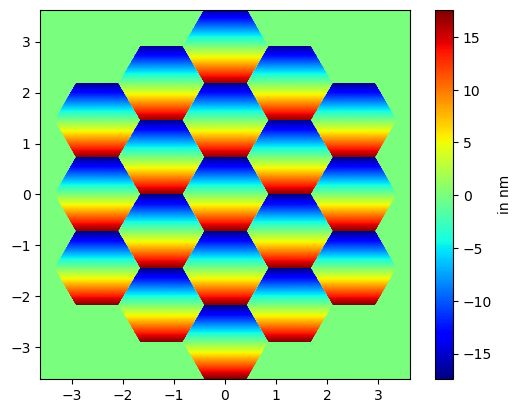

In [10]:
tel2.sm.flatten()

for hwo_seg in range(0, tel2.nseg):
    scda_seg = hwo_to_scda[str(hwo_seg + 1)] - 1
    for hexike in range(0, n_zernikes):
        tel2.sm.actuators[hexike + scda_seg * n_zernikes] = tel2_actuators[1][hexike + scda_seg * n_zernikes]
        
plt.figure()
hcipy.imshow_field(tel2.sm.surface*1e9, cmap='jet')
cbar = plt.colorbar()
cbar.set_label("in nm", loc='center')

### Run time-series for all DOFs. 

In [ ]:
tel2.sm.flatten()
dx_times = []
for time in range(0, 401):
    dx = time_series[:, time*6] * 1e12 # in units of pm. 
    dx = np.delete(dx, -1)
    dx_times.append(dx)

dy_times = []
for time in range(0, 401):
    dy = time_series[:, time*6 + 1] * 1e12 # in units of pm. 
    dy = np.delete(dy, -1)
    dy_times.append(dy)
    
dz_times = []
for time in range(0, 401):
    dz = time_series[:, time*6 + 2] * 1e12 # in units of pm. 
    dz = np.delete(dz, -1)
    dz_times.append(dz) 
    
rdx_times = []
for time in range(0, 401):
    rdx = time_series[:, time*6 + 3] * 1e12 # in units of pm. 
    rdx = np.delete(rdx, -1)
    rdx_times.append(rdx)
    
    
rdy_times = []
for time in range(0, 401):
    rdy = time_series[:, time*6 + 4] * 1e12 # in units of pm. 
    rdy = np.delete(rdy, -1)
    rdy_times.append(rdy)
    
rdz_times = []
for time in range(0, 401):
    rdz = time_series[:, time*6 + 5] * 1e12 # in units of pm. 
    rdz = np.delete(rdz, -1)
    rdz_times.append(rdz)
    

contrasts_dof = []
for time in range(0, 401):
    tel2.sm.flatten()
    for hwo_seg in range(0, tel2.nseg):
        scda_seg = hwo_to_scda[str(hwo_seg + 1)] - 1
        for hexike in range(0, n_zernikes):
            dox = tel2_actuators[0][hexike + scda_seg * n_zernikes] * dx_times[time][hwo_seg] * 1e-6
            doy = tel2_actuators[1][hexike + scda_seg * n_zernikes] * dy_times[time][hwo_seg] * 1e-6
            doz = tel2_actuators[2][hexike + scda_seg * n_zernikes] * dz_times[time][hwo_seg] * 1e-6
            rdx = tel2_actuators[3][hexike + scda_seg * n_zernikes] * rdx_times[time][hwo_seg] * 1e-6
            rdy = tel2_actuators[4][hexike + scda_seg * n_zernikes] * rdy_times[time][hwo_seg] * 1e-6
            rdz = tel2_actuators[5][hexike + scda_seg * n_zernikes] * rdz_times[time][hwo_seg] * 1e-6
            tel2.sm.actuators[hexike + scda_seg * n_zernikes] =  dox + doy + doz + rdx + rdy + rdz
    

    aberrated_psf, ref, intermediates = tel2.calc_psf(ref=True, display_intermediate=False, return_intermediate='intensity',norm_one_photon=True)
    normalized_aberrated_psf = aberrated_psf / norm
    aberr_roi = normalized_aberrated_psf * tel2.dh_mask
    aber_contrast_floor = np.mean(aberr_roi[np.where(tel2.dh_mask != 0)])
    contrasts_dof.append(aber_contrast_floor)
    print("contrast_floor:", aber_contrast_floor)

contrast_floor: 4.313881308155215e-11
contrast_floor: 4.359208049493887e-11
contrast_floor: 4.3592327226406637e-11
contrast_floor: 4.316360090120595e-11
contrast_floor: 4.290007318274017e-11
contrast_floor: 4.282393095307058e-11
contrast_floor: 4.314680325998106e-11
contrast_floor: 4.3175117482703836e-11
contrast_floor: 4.339628972236274e-11
contrast_floor: 4.3465695512145706e-11
contrast_floor: 4.334107479445651e-11
contrast_floor: 4.335175052143477e-11
contrast_floor: 4.338608053922065e-11
contrast_floor: 4.357799236561132e-11
contrast_floor: 4.380437004617831e-11
contrast_floor: 4.399382986744417e-11
contrast_floor: 4.421108106285961e-11
contrast_floor: 4.416346600483969e-11
contrast_floor: 4.4250360356495363e-11
contrast_floor: 4.400433242741475e-11
contrast_floor: 4.394547598577276e-11
contrast_floor: 4.4030325944891815e-11
contrast_floor: 4.4258986468352694e-11
contrast_floor: 4.391894806438432e-11
contrast_floor: 4.4083852645942735e-11
contrast_floor: 4.4492747975556906e-11
cont

contrast_floor: 4.4332674872288874e-11
contrast_floor: 4.383151090289599e-11
contrast_floor: 4.3750815583698697e-11
contrast_floor: 4.391788342457341e-11
contrast_floor: 4.407577048389061e-11
contrast_floor: 4.418407905425225e-11
contrast_floor: 4.440745958177745e-11
contrast_floor: 4.444723913379654e-11
contrast_floor: 4.444198479180214e-11
contrast_floor: 4.4102601381346144e-11
contrast_floor: 4.414557169799451e-11
contrast_floor: 4.402143293559948e-11
contrast_floor: 4.4380414136626565e-11
contrast_floor: 4.456498216853574e-11
contrast_floor: 4.4642764484041983e-11
contrast_floor: 4.4614727316801046e-11
contrast_floor: 4.477263906450095e-11
contrast_floor: 4.5004280551871106e-11
contrast_floor: 4.5214123762444e-11
contrast_floor: 4.521025889791432e-11
contrast_floor: 4.5500265327433367e-11
contrast_floor: 4.53705233616725e-11
contrast_floor: 4.488753421990769e-11
contrast_floor: 4.4579602700749196e-11
contrast_floor: 4.446679490618699e-11
contrast_floor: 4.448176347231754e-11
contra

In [ ]:
plt.figure(figsize=(20, 10))
times = np.arange(0, 401, 1)
plt.plot(times, contrasts_dof, marker='s', markersize=8, linewidth=2, label='total')
plt.axhline(y=4.171337358217274e-11, color='r', linestyle='--', label='contrast_floor')
#plt.ylim(4.1e-11, 5.25e-11)
plt.ylabel("Mean DH Contrast", fontsize=25)
plt.xlabel("Time (in s)", fontsize=25)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig(os.path.join(analysis_path, ''))

Note, check that time_series[0, 6] should be equal to dx_times[1][0] if the sorting is correct. 